In [32]:
import numpy as np
import matplotlib.pyplot as plt
from numba import vectorize, njit

import utils
import jacobian as jac
from het_block import het
from simple_block import simple

In [33]:
def rbc_ss(r=0.01, eis=1, frisch=1, delta=0.025, alpha=0.11):
    """Solve steady state of simple RBC model.
        
    Parameters
    ----------
    r      : scalar, real interest rate
    eis    : scalar, elasticity of intertemporal substitution (1/sigma)
    frisch : scalar, Frisch elasticity (1/nu)
    delta  : scalar, depreciation rate
    alpha  : scalar, capital share

    Returns
    -------
    ss : dict, steady state values
    """
    # solve for aggregates analytically
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * K ** alpha
    I = delta * K
    C = Y - I
    
    # preference params
    beta = 1 / (1 + r)
    vphi = w * C ** (-1 / eis)
    
    # check Walras's law
    walras = C - r * K - w
    assert np.abs(walras) < 1E-12

    return {'beta': beta, 'eis': eis, 'frisch':frisch, 'vphi': vphi, 'delta': delta, 'alpha': alpha,
            'Z': Z, 'K': K, 'I': I, 'Y': Y, 'L': 1, 'C': C, 'w': w, 'r': r, 'rk': rk, 'q': 1, 'walras': walras}

In [34]:
ss0=rbc_ss()
ss0

{'beta': 0.9900990099009901,
 'eis': 1,
 'frisch': 1,
 'vphi': 0.9658914728682173,
 'delta': 0.025,
 'alpha': 0.11,
 'Z': 0.8816460975214567,
 'K': 3.1428571428571432,
 'I': 0.07857142857142858,
 'Y': 1.0,
 'L': 1,
 'C': 0.9214285714285714,
 'w': 0.8900000000000001,
 'r': 0.01,
 'rk': 0.035,
 'q': 1,
 'walras': -2.220446049250313e-16}

In [35]:
@simple
def firm(K, L, Z, q, alpha, delta):
    rk = alpha * Z * (K(-1) / L) ** (alpha-1) 
    r = rk/q(-1) + (1-delta) * q / q(-1) - 1
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, rk,  w, Y

@simple
def household0(K, L, w, eis, frisch, vphi, delta):
    C = (w / vphi / L ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing0(r, rk, C, Y, I, K, L, w, q, eis, beta, delta):
    goods_mkt = Y - C - q * I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + rk - delta) * K(-1) - w * L  # we can the check dynamic version too
    return goods_mkt, euler, walras

In [36]:
T = 300
G0 = jac.get_G(block_list=[firm, household0, mkt_clearing0],
              exogenous=['Z', 'q'],
              unknowns=['K', 'L'],
              targets=['euler', 'goods_mkt'],
              T=T, ss=ss0)

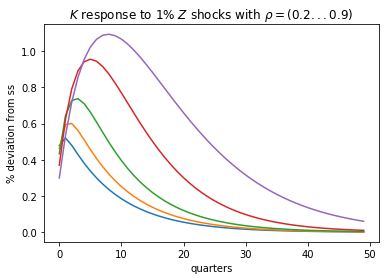

In [37]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
dZ0 = 0.01*ss0['Z']*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dK = G0['K']['Z'] @ dZ0 /ss0['K']
plt.plot(100*dK[:50, :])
plt.title(r'$K$ response to 1% $Z$ shocks with $\rho=(0.2 ... 0.9)$')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

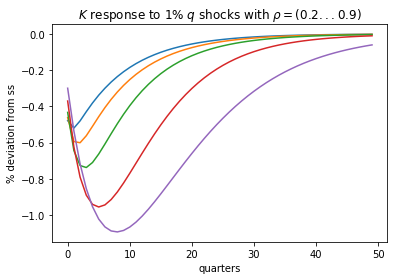

In [38]:
dq0 = 0.01*ss0['q']*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dK = G0['K']['q'] @ dq0 /ss0['K']
plt.plot(100*dK[:50, :])
plt.title(r'$K$ response to 1% $q$ shocks with $\rho=(0.2 ... 0.9)$')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

In [39]:
@het(exogenous='Pi', policy='a', backward='Va')
def household1(Va_p, Pi_p, a_grid, e_grid, w, r, beta, eis, frisch, vphi, c_const, n_const, ssflag=False):
    """Single backward iteration step using endogenous gridpoint method for households with separable CRRA utility."""
    # this one is useful to do internally
    ws = w * e_grid

    # uc(z_t, a_t)
    uc_nextgrid = (beta * Pi_p) @ Va_p

    # c(z_t, a_t) and n(z_t, a_t)
    c_nextgrid, n_nextgrid = cn(uc_nextgrid, ws[:, np.newaxis], eis, frisch, vphi)

    # c(z_t, a_{t-1}) and n(z_t, a_{t-1})
    lhs = c_nextgrid - ws[:, np.newaxis] * n_nextgrid + a_grid[np.newaxis, :]
    rhs = (1 + r) * a_grid
    c = utils.interpolate_y(lhs, rhs, c_nextgrid)
    n = utils.interpolate_y(lhs, rhs, n_nextgrid)

    # test constraints, replace if needed
    a = rhs + ws[:, np.newaxis] * n - c
    iconst = np.nonzero(a < a_grid[0])
    a[iconst] = a_grid[0]

    if ssflag:
        # use precomputed values
        c[iconst] = c_const[iconst]
        n[iconst] = n_const[iconst]
    else:
        # have to solve again if in transition
        uc_seed = c_const[iconst] ** (-1 / eis)
        c[iconst], n[iconst] = solve_cn(ws[iconst[0]],
                                        rhs[iconst[1]] - a_grid[0], eis, frisch, vphi, uc_seed)

    # calculate marginal utility to go backward
    Va = (1 + r) * c ** (-1 / eis)

    # efficiency units of labor which is what really matters
    ns = e_grid[:, np.newaxis] * n

    return Va, a, c, n, ns


@njit
def cn(uc, w, eis, frisch, vphi):
    """Return optimal c, n as function of u'(c) given parameters"""
    return uc ** (-eis), (w * uc / vphi) ** frisch


def solve_cn(w, T, eis, frisch, vphi, uc_seed):
    uc = solve_uc(w, T, eis, frisch, vphi, uc_seed)
    return cn(uc, w, eis, frisch, vphi)


@vectorize
def solve_uc(w, T, eis, frisch, vphi, uc_seed):
    """Solve for optimal uc given in log uc space.

    max_{c, n} c**(1-1/eis) + vphi*n**(1+1/frisch) s.t. c = w*n + T
    """
    log_uc = np.log(uc_seed)
    for i in range(30):
        ne, ne_p = netexp(log_uc, w, T, eis, frisch, vphi)
        if abs(ne) < 1E-11:
            break
        else:
            log_uc -= ne / ne_p
    else:
        raise ValueError("Cannot solve constrained household's problem: No convergence after 30 iterations!")

    return np.exp(log_uc)


@njit
def netexp(log_uc, w, T, eis, frisch, vphi):
    """Return net expenditure as a function of log uc and its derivative."""
    c, n = cn(np.exp(log_uc), w, eis, frisch, vphi)
    ne = c - w * n - T

    # c and n have elasticities of -eis and frisch wrt log u'(c)
    c_loguc = -eis * c
    n_loguc = frisch * n
    netexp_loguc = c_loguc - w * n_loguc

    return ne, netexp_loguc


In [40]:
@simple
def mkt_clearing1(A, NS, C, L, Y, K, I, q):
    asset_mkt = A - K
    labor_mkt = NS - L
    goods_mkt = Y - C - q*I
    return asset_mkt, labor_mkt, goods_mkt


In [41]:
'''Part 3: Steady state'''

def ks_ss(beta_guess=0.98,vphi_guess=0.98, r=0.01, delta=0.025, alpha =1/3, eis=1, frisch=1,
           rho_s=0.9, sigma_s=0.3, nS=8, amax=100, nA=500):
    """Solve steady state of full GE model. Calibrate (beta, vphi) to hit target for interest rate and Y."""

    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_e, Pi = utils.markov_rouwenhorst(rho=rho_s, sigma=sigma_s, N=nS)
    
    # solve analytically what we can
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    w = (1 - alpha) * Z * (alpha * Z / rk) ** (alpha / (1 - alpha))
    I = delta * K

    # initialize guess for policy function iteration
    fininc = (1 + r) * a_grid - a_grid[0]
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)

    # residual function
    def res(x):
        beta_loc, vphi_loc = x
        # precompute constrained c and n which don't depend on Va
        c_const_loc, n_const_loc = solve_cn(w * e_grid[:, np.newaxis],fininc, eis, frisch, vphi_loc, Va)
        if beta_loc > 0.999 / (1 + r) or vphi_loc < 0.001:
            raise ValueError('Clearly invalid inputs')
        out = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta_loc,
                           eis=eis, frisch=frisch, vphi=vphi_loc, c_const=c_const_loc, n_const=n_const_loc,ssflag=True)
        return np.array([out['A'] - K, out['NS'] - 1])

    # solve for beta, vphi
    (beta, vphi), _ = utils.broyden_solver(res, np.array([beta_guess, vphi_guess]), noisy=False)

    # extra evaluation for reporting
    c_const, n_const = solve_cn(w * e_grid[:, np.newaxis],fininc, eis, frisch, vphi, Va)
    ss = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta, eis=eis,
                      frisch=frisch, vphi=vphi, c_const=c_const, n_const=n_const, ssflag=True)
    
    # check Walras's law
    goods_mkt = ss['C'] + I - 1
    assert np.abs(goods_mkt) < 1E-7
    
    # add aggregate variables
    ss.update({'Y': 1, 'L': 1, 'K': K, 'Z': Z, 'I': I, 'w': w, 'r': r, 'rk': rk, 'q' : 1,
               'beta': beta, 'vphi': vphi, 'alpha': alpha, 'delta': delta, 
               'frisch': frisch, 'a_grid': a_grid, 'e_grid': e_grid,  'goods_mkt': goods_mkt})
    return ss

In [42]:
ss1=ks_ss()

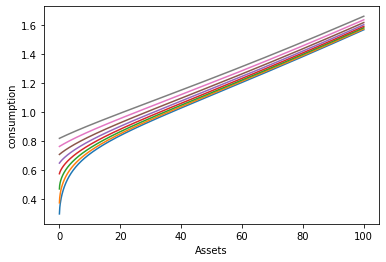

In [43]:
plt.plot(ss1['a_grid'], ss1['c'].T)
plt.xlabel('Assets'), plt.ylabel('consumption')
plt.show()

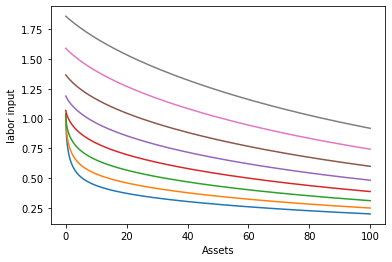

In [44]:
plt.plot(ss1['a_grid'], ss1['n'].T)
plt.xlabel('Assets'), plt.ylabel('labor input')
plt.show()

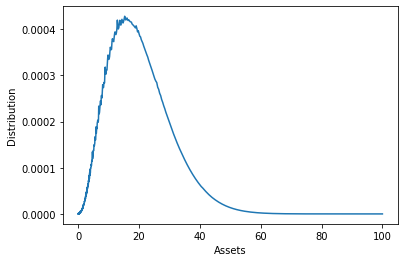

In [45]:
plt.plot(ss1['a_grid'], ss1['D'][6])
plt.xlabel('Assets'), plt.ylabel('Distribution')
plt.show()

In [46]:
T = 300
G1 = jac.get_G(block_list=[firm, mkt_clearing1, household1],
               exogenous=['Z','q'],
               unknowns=['K','L'],
               targets=['asset_mkt','labor_mkt'],
               T=T, ss=ss1)

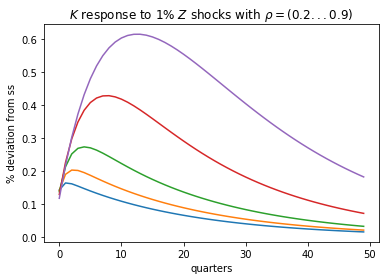

In [47]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
dZ1 = 0.01*ss1['Z']*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dK = G1['K']['Z'] @ dZ1 /ss1['K']
plt.plot(100*dK[:50, :])
plt.title(r'$K$ response to 1% $Z$ shocks with $\rho=(0.2 ... 0.9)$')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

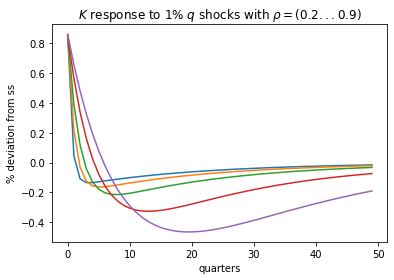

In [65]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
dq1 = 0.01*ss1['q']*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dK = G1['K']['q'] @ dq1 /ss1['K']
plt.plot(100*dK[:50, :])
plt.title(r'$K$ response to 1% $q$ shocks with $\rho=(0.2 ... 0.9)$')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

In [49]:
def rbc_ss(beta=0.99, vphi = 1, Z = 1, delta=0.025, alpha =1/3, eis=1, frisch=1):
    """Solve steady state of simple RBC model.
        
    Parameters
    ----------
    r      : scalar, real interest rate
    eis    : scalar, elasticity of intertemporal substitution (1/sigma)
    frisch : scalar, Frisch elasticity (1/nu)
    delta  : scalar, depreciation rate
    alpha  : scalar, capital share

    Returns
    -------
    ss : dict, steady state values
    """
    # solve for aggregates analytically
    r = 1/beta - 1
    rk = r + delta
    KL = (rk/alpha/Z) ** (1/(alpha-1))
    L = (1-alpha)*Z*KL**alpha * KL**(-1/eis)/vphi
    L = L*(Z*KL**(alpha-1)-delta)**(-1/eis)
    L = L**(1/(1/eis+1/frisch))
    K = L*KL
    Y = Z * K ** alpha * L ** (1-alpha)
    w = (1 - alpha) * Z * KL ** alpha 
    I = delta * K
    C = Y - I
        
    # check Walras's law
    walras = Y - rk * K - w * L
    assert np.abs(walras) < 1E-12

    return {'beta': beta, 'eis': eis, 'frisch':frisch, 'vphi': vphi, 'delta': delta, 'alpha': alpha,
            'Z': Z, 'K': K, 'I': I, 'Y': Y, 'L': L, 'C': C, 'w': w, 'r': r, 'rk' : rk,'q': 1, 'walras': walras}

In [50]:
ss2 = rbc_ss(beta = ss1['beta'],vphi = ss1['vphi'],Z = ss1['Z'])

In [51]:
T = 300
G2 = jac.get_G(block_list=[firm, household0, mkt_clearing0],
              exogenous=['Z', 'q'],
              unknowns=['K', 'L'],
              targets=['euler', 'goods_mkt'],
              T=T, ss=ss2)

In [52]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
dZ2 = 0.01*ss2['Z']*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dq2 = 0.01*ss1['q']*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ

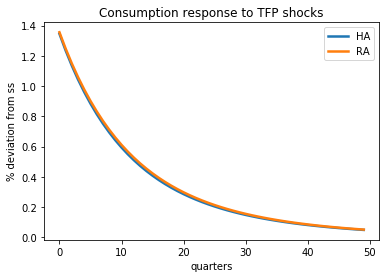

In [62]:
idx = 'Y'
dY1 = 100 * G1[idx]['Z'] @ dZ1 / ss1[idx]
dY2 = 100 * G2[idx]['Z'] @ dZ2 / ss2[idx]
plt.plot(dY1[:50,4], label='HA', linewidth=2.5)
plt.plot(dY2[:50,4], label='RA', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

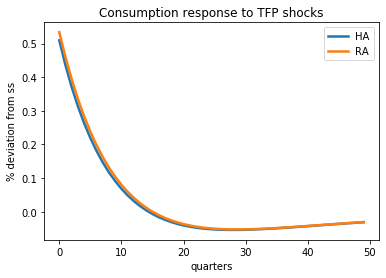

In [59]:
dY1 = 100 * G1['N']['Z'] @ dZ1 / ss1['N']
dY2 = 100 * G2['L']['Z'] @ dZ2 / ss2['L']
plt.plot(dY1[:50,4], label='HA', linewidth=2.5)
plt.plot(dY2[:50,4], label='RA', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

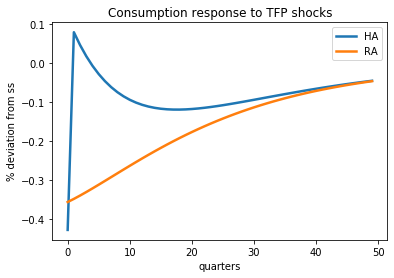

In [63]:
idx = 'Y'
dY1 = 100 * G1[idx]['q'] @ dq1 / ss1[idx]
dY2 = 100 * G2[idx]['q'] @ dq2 / ss2[idx]
plt.plot(dY1[:50,4], label='HA', linewidth=2.5)
plt.plot(dY2[:50,4], label='RA', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

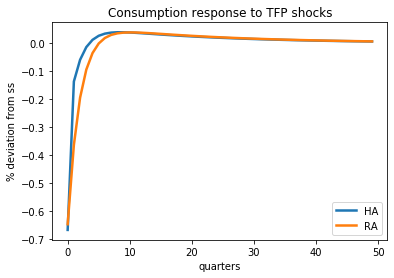

In [25]:
dY1 = 100 * G1['N']['q'] @ dq1 / ss1['N']
dY2 = 100 * G2['L']['q'] @ dq2 / ss2['L']
plt.plot(dY1[:50,2], label='HA', linewidth=2.5)
plt.plot(dY2[:50,2], label='RA', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

In [26]:
ss1['NS']

1.000000000020649